In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file = '/content/drive/MyDrive/FOOD.zip'

In [4]:
import zipfile as zf
data_zip = zf.ZipFile(file)
data_zip.extractall()
!ls

 drive	'Food Classification dataset'   sample_data


In [5]:
from pathlib import Path
data = Path(r'/content/Food Classification dataset')

In [6]:
images=[]
import os
for dirname,_,filenames in os.walk(data):
  for filename in filenames:
    file_name, file_extension = os.path.splitext(filename)
    if file_extension == '.db':
      continue
    else:
      img=os.path.join(dirname,filename)
      images.append(img)

In [7]:
images[:20]

['/content/Food Classification dataset/idli/images (19).jpg',
 '/content/Food Classification dataset/idli/180.jpg',
 '/content/Food Classification dataset/idli/135.jpg',
 '/content/Food Classification dataset/idli/159.jpg',
 '/content/Food Classification dataset/idli/065.jpg',
 '/content/Food Classification dataset/idli/106.jpg',
 '/content/Food Classification dataset/idli/115.jpg',
 '/content/Food Classification dataset/idli/234.jpg',
 '/content/Food Classification dataset/idli/001.jpg',
 '/content/Food Classification dataset/idli/243.jpg',
 '/content/Food Classification dataset/idli/119.jpg',
 '/content/Food Classification dataset/idli/043.jpg',
 '/content/Food Classification dataset/idli/197.jpg',
 '/content/Food Classification dataset/idli/236.jpg',
 '/content/Food Classification dataset/idli/050.jpg',
 '/content/Food Classification dataset/idli/292.jpg',
 '/content/Food Classification dataset/idli/232.jpg',
 '/content/Food Classification dataset/idli/198.jpg',
 '/content/Food Clas

In [8]:
len(images)

23873

In [9]:
class_values = []
for i in images:
    j = i.split('/')
    class_values.append(j[-2])

In [10]:
class_values[:10]

['idli',
 'idli',
 'idli',
 'idli',
 'idli',
 'idli',
 'idli',
 'idli',
 'idli',
 'idli']

In [11]:
len(class_values)

23873

In [12]:
import random # Import the random module at the beginning of the cell
temp = list(zip(images,class_values))
random.shuffle(temp)
images, class_values = zip(*temp)
data = pd.DataFrame(list(zip(images, class_values)), columns=['image_path', 'Class_label'])

In [13]:
data

,image_path,Class_label
0,/content/Food Classification dataset/cheesecak...,cheesecake
1,/content/Food Classification dataset/chapati/2...,chapati
2,/content/Food Classification dataset/Sandwich/...,Sandwich
3,/content/Food Classification dataset/Taquito/T...,Taquito
4,/content/Food Classification dataset/chicken_c...,chicken_curry
...,...,...
23868,/content/Food Classification dataset/Taco/Taco...,Taco
23869,/content/Food Classification dataset/cheesecak...,cheesecake
23870,/content/Food Classification dataset/Baked Pot...,Baked Potato
23871,/content/Food Classification dataset/Baked Pot...,Baked Potato


In [14]:
data.shape

(23873, 2)

In [15]:
data.Class_label.value_counts()

,count
Class_label,
Hot Dog,1548
Sandwich,1500
Taco,1500
Baked Potato,1500
Donut,1500
Taquito,1500
Fries,1500
Crispy Chicken,1500
ice_cream,1000


In [16]:
from sklearn.utils import resample

# Convert to DataFrame
df = data.copy()

# Number of samples per class
TARGET_COUNT = 500
balanced_df = []

# Loop over each unique class
for label in df['Class_label'].unique():
    df_class = df[df['Class_label'] == label]

    # Resample
    df_resampled = resample(df_class,
                            replace=True,
                            n_samples=TARGET_COUNT,
                            random_state=42)
    balanced_df.append(df_resampled)

# Concatenate all into one DataFrame
balanced_df = pd.concat(balanced_df).reset_index(drop=True)

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Final check
print(balanced_df['Class_label'].value_counts())


Class_label
momos             500
Fries             500
idli              500
chicken_curry     500
Hot Dog           500
apple_pie         500
pakode            500
ice_cream         500
pav_bhaji         500
samosa            500
cheesecake        500
chole_bhature     500
jalebi            500
fried_rice        500
omelette          500
dal_makhani       500
masala_dosa       500
sushi             500
dhokla            500
butter_naan       500
Crispy Chicken    500
Sandwich          500
paani_puri        500
pizza             500
Baked Potato      500
kaathi_rolls      500
Taco              500
kadai_paneer      500
burger            500
kulfi             500
chai              500
Taquito           500
Donut             500
chapati           500
Name: count, dtype: int64


In [17]:
balanced_df['Class_label'] = balanced_df['Class_label'].astype(str)

In [18]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['Class_label'],
    random_state=42
)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [20]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='Class_label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='Class_label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 13600 validated image filenames belonging to 34 classes.
Found 3400 validated image filenames belonging to 34 classes.


In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# Get number of classes from train_generator
num_classes = len(train_generator.class_indices)

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,338 (9.26 MB)

 Trainable params: 168,354 (657.63 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
EPOCHS = 30

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
226/425 ━━━━━━━━━━━━━━━━━━━━ 2:03 622ms/step - accuracy: 0.0543 - loss: 3.7507

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


425/425 ━━━━━━━━━━━━━━━━━━━━ 316s 714ms/step - accuracy: 0.0800 - loss: 3.5859 - val_accuracy: 0.4347 - val_loss: 2.4329
Epoch 2/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 283s 666ms/step - accuracy: 0.3240 - loss: 2.5248 - val_accuracy: 0.6503 - val_loss: 1.5107
Epoch 3/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 290s 682ms/step - accuracy: 0.4733 - loss: 1.8822 - val_accuracy: 0.7074 - val_loss: 1.1701
Epoch 4/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 330s 701ms/step - accuracy: 0.5526 - loss: 1.5816 - val_accuracy: 0.7376 - val_loss: 1.0134
Epoch 5/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 316s 744ms/step - accuracy: 0.5925 - loss: 1.4087 - val_accuracy: 0.7506 - val_loss: 0.9222
Epoch 6/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 325s 749ms/step - accuracy: 0.6324 - loss: 1.2720 - val_accuracy: 0.7671 - val_loss: 0.8610
Epoch 7/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 313s 738ms/step - accuracy: 0.6539 - loss: 1.1972 - val_accuracy: 0.7729 - val_loss: 0.8176
Epoch 8/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 319s 730ms/step - accuracy: 0.6647 - loss: 1.13

In [25]:
model.save("Food.h5")

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 355ms/step - accuracy: 0.8586 - loss: 0.5040
Validation Accuracy: 84.94%


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get true labels from val_generator
y_true_classes = val_generator.classes

# Predict on the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report
print("Classification Report:")
# Assuming 'enc' is a LabelBinarizer or similar object you've defined elsewhere
print(classification_report(y_true_classes, y_pred_classes, target_names=train_generator.class_indices))

107/107 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step
Classification Report:
                precision    recall  f1-score   support

  Baked Potato       0.92      0.73      0.82       100
Crispy Chicken       0.97      0.71      0.82       100
         Donut       0.89      0.95      0.92       100
         Fries       0.91      0.86      0.88       100
       Hot Dog       0.88      0.87      0.87       100
      Sandwich       0.79      0.78      0.78       100
          Taco       0.72      0.55      0.62       100
       Taquito       0.86      0.49      0.62       100
     apple_pie       0.74      0.75      0.74       100
        burger       0.93      0.99      0.96       100
   butter_naan       0.86      0.85      0.85       100
          chai       0.87      0.98      0.92       100
       chapati       0.82      0.80      0.81       100
    cheesecake       0.82      0.79      0.81       100
 chicken_curry       0.80      0.65      0.72       100
 chole_bhature       0.82      0.89 

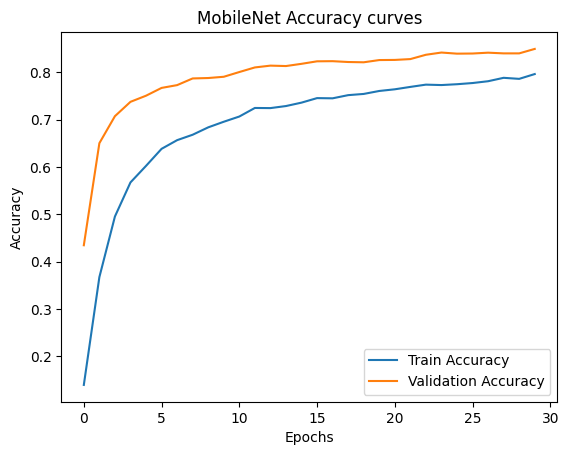

In [30]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("MobileNet Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

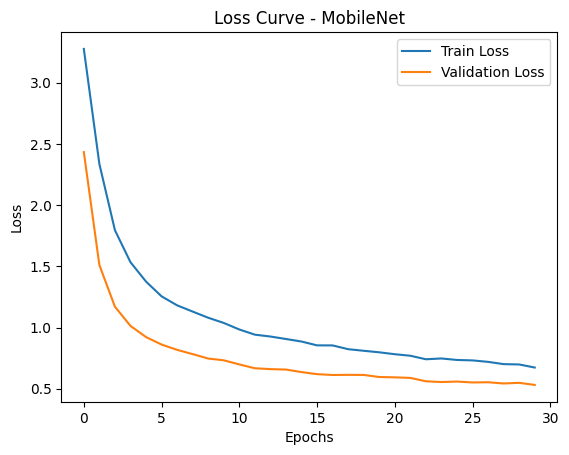

In [31]:
# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step


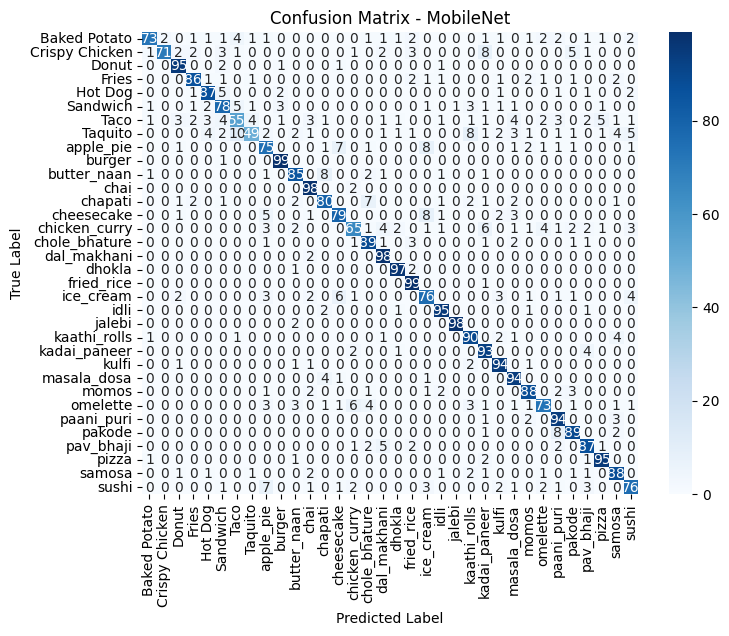

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get true labels from val_generator
y_true_classes = val_generator.classes  # True class labels (no need for y_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_generator.class_indices,  # Use train_generator.class_indices for class names
    yticklabels=train_generator.class_indices,  # Use train_generator.class_indices for class names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MobileNet")
plt.show()